#MA5851 Assignment Document 3: NLP Tasks

Monique Lower

#NLP Task 1 – Topic Modelling


##Review and Rational 

Topic Modelling is an unsupervised technique that seeks to group patterns of words into categories or topics, which then  need to be interpreted by the data scientist in order to complete analysis on the documents that make up the corpus (Jacobi, van Attervelt, & Welbers, 2016). In newspaper analysis, it would be expected that topics would align with categories such as politics, crime, sports, but the Latent Dirichlet allocation (LDA)  algorithm automatically creates topics based on patterns, which means that the resulting categories may not align to issues or themes, but may align with writing styles, events or speech (Jacobi, van Attervelt, & Welbers, 2016). LDA is a modelling technique explaining through unobserved groups, observations based on data similarity, for example basketball or football would show a high probably of alignment to sport, whilst the words network and data would have strong alignment to computers (Tong & Zhang, 2016).
This task will consist of LDA Topic Modelling performed on the combined title and description field from the corpus, LDA as a technique is able to reliable produce interpretable groups or topics based on the corpus input into the model, which is ideal for news headlines which will change based on local and world events (Rao & Taboda, 2021).  


### Setting up the environment


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade gensim==3.8

import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip


import pandas as pd
import nltk
nltk.download('stopwords')
! pip install spacy
! pip install pyLDAvis
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### importing the cleaned dataset

In [149]:
#Importing the dataset
df = pd.read_csv("/content/drive/My Drive/Assessment_3/cleaned_dataset.csv")

Titles = df['Together'].str.cat(sep = '')
df.head(5)



,Unnamed: 0,index,Title,Description,Section,Paper,Together
0,0,1,scott morrison confirms australia s diplomatic...,the prime minister has confirmed australia wil...,federal,The Age,scott morrison confirms australia s diplomatic...
1,1,2,desperate triple zero calls unanswered as a li...,victoria s triple zero service is supposed to ...,state,The Age,desperate triple zero calls unanswered as a li...
2,2,3,australia news live nsw s omicron covid cluste...,another liberal elder has encouraged gladys be...,misc news,The Age,australia news live nsw s omicron covid cluste...
3,3,4,ashes first test live updates root dismissed f...,australia are off to a dream start at the gabb...,sport,The Age,ashes first test live updates root dismissed f...
4,4,6,not just another alpha male how pat cummins wi...,life has never been all about cricket for aust...,sport,The Age,not just another alpha male how pat cummins wi...


## Feature Normalisation / Data Pre-Processing


The cleaned corpus required additional pre-processing prior to the application of the topic model, 

*   	Creation of bigram and trigram phrases in the dataset, no minimum threshold has been called out due to the small size of the dataset
*  Removal of stop words 
*   Lemmatization of words defined as the conversion of a word to a root by removing suffixes (Chapman, Nadkarni, & Ohno-Machado, 2011).
*  Creation of the Dictionary using Lemmatized bigrams
*   Creation of the Corpus 


In [150]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'us', 'abc', 'australia', 'australian', 'year', 'aussies', 'news', 'day', 'be', 'use', 's', 'be', 'get', 'say'])


In [151]:
# Convert to list
data = df.Together.values.tolist()


In [152]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['scott', 'morrison', 'confirms', 'australia', 'diplomatic', 'boycott', 'of', 'beijing', 'olympicsthe', 'prime', 'minister', 'has', 'confirmed', 'australia', 'will', 'not', 'send', 'officials', 'to', 'the', 'upcoming', 'winter', 'olympics']]


In [153]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['scott', 'morrison', 'confirms', 'australia', 'diplomatic_boycott', 'of', 'beijing', 'olympicsthe', 'prime', 'minister', 'has', 'confirmed', 'australia', 'will', 'not', 'send', 'officials', 'to', 'the', 'upcoming', 'winter_olympics']


In [154]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [155]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_words_nostops)


print(data_lemmatized[:1])

[['scott', 'morrison', 'confirms', 'diplomatic', 'boycott', 'beijing', 'olympicsthe', 'prime', 'minister', 'confirmed', 'send', 'officials', 'upcoming', 'winter', 'olympics'], ['desperate', 'triple', 'zero', 'calls', 'unanswered', 'life', 'ticked', 'awayvictoria', 'triple', 'zero', 'service', 'supposed', 'work', 'seamlessly', 'nick', 'panagiotopoulos', 'tried', 'call', 'ambulance', 'october', 'something', 'went', 'terribly', 'wrong'], ['live', 'nsw', 'omicron', 'covid', 'cluster', 'grows', 'first', 'ashes', 'test', 'begins', 'brisbaneanother', 'liberal', 'elder', 'encouraged', 'gladys', 'berejiklian', 'run', 'federal', 'politics', 'victoria', 'coronavirus', 'outbreak', 'slowing', 'changing', 'shape', 'send', 'officials', 'china', 'winter', 'olympics'], ['ashes', 'first', 'test', 'live', 'updates', 'root', 'dismissed', 'duck', 'starc', 'strikes', 'first', 'ballaustralia', 'dream', 'start', 'gabba', 'mitchell', 'starc', 'took', 'wicket', 'first', 'ball', 'series'], ['another', 'alpha', '

In [156]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1)]]


In [157]:
id2word[0]

'confirm'

In [158]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('confirm', 2), ('official', 1), ('upcome', 1)]]

##Application of the LDA Model  / Hyperparameters


The initial machine learning algorithm applied is the LDA model from the gensim library in Python, LDA uses a probabilistic algorithm to align text to unspecified topics, which may not align to human categorisation (AWS, 2021). Documents within a topic group may not share the same content, but they should share more characteristics than a document from a different topic group (AWS, 2021).

Initial hyperparameters selected for the LDA model are

*  Number of topics: 8
*  Random rate: 100 (To ensure consistent results are achieved using the same dataset on each pass) 
*  Update_Every: 1 
*  Chunk size: 100
*  Alpha: ‘auto’
*  Per_word_Topics: True

As the corpus is small in this instance, computational effort is not a consideration, the Number of topics was set to 8 as the initial pass to increase the group sizes.





In [159]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [160]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"border" + 0.013*"great" + 0.011*"ahead" + 0.011*"high" + '
  '0.010*"open" + 0.008*"political" + 0.008*"pay" + 0.008*"year" + '
  '0.008*"reopen" + 0.007*"call"'),
 (1,
  '0.013*"make" + 0.010*"live" + 0.010*"ash" + 0.010*"movie" + 0.010*"expect" '
  '+ 0.008*"help" + 0.008*"week" + 0.008*"join" + 0.008*"show" + '
  '0.008*"program"'),
 (2,
  '0.013*"state" + 0.010*"family" + 0.009*"covid" + 0.009*"ask" + 0.009*"home" '
  '+ 0.008*"friend" + 0.008*"tell" + 0.008*"good" + 0.008*"year" + '
  '0.008*"game"'),
 (3,
  '0.013*"take" + 0.012*"variant" + 0.012*"police" + 0.011*"see" + '
  '0.011*"spend" + 0.010*"ashe" + 0.010*"local" + 0.008*"asset" + 0.008*"go" + '
  '0.008*"much"'),
 (4,
  '0.013*"know" + 0.012*"market" + 0.011*"life" + 0.010*"help" + 0.010*"still" '
  '+ 0.010*"world" + 0.010*"man" + 0.010*"company" + 0.009*"give" + '
  '0.009*"may"'),
 (5,
  '0.016*"vaccine" + 0.013*"old" + 0.012*"use" + 0.012*"abuse" + 0.011*"get" + '
  '0.011*"say" + 0.011*"child" + 0.009*

One measure of the LDA model performance is around the coherence score, a lower score indicates a noisy or sparse dataset where the multinomial distribution is not sufficient enough to produce the top 10 most probable words, but may contain some words that may vaguely be interpretable, or be completely unrelated (Buntine, Bonilla, & Newman, 2011).  The perplexity score relates to how predictable the text the algorithm is ‘seeing’ is (Frankenberg, et al., 2019), the lower a perplexity score is the less surprised the model is by the text (Kapadia, 2019)

The initial result indicates that the coherence score is relatively low, which is not unexpected due to the sparse corpus.


In [161]:

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.045710777644873

Coherence Score:  0.5333514557905927



Figure 1 shows the resulting topical groupings based on the initial pass of the model, the ideal model has larger sized bubbles, that have little overlap and are evenly spread throughout the grid (Pranhakaran, 2018)

In [179]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis
print("Figure 1 Results of the initial 8 grouping after applying the LDA model" )

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Figure 1 Results of the initial 8 grouping after applying the LDA model


An alternative model to gensim in python is mallet, this model is a java based application and has higher quality topics, it relies on Gibbs sampling which is more precise but has a higher computational time than Gensim which uses Variational Bayes sampling (Naskar, 2021)

In [163]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [164]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [165]:
import os
from gensim.models.wrappers import LdaMallet
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels

#Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = '/content/drive/My Drive/Assessment_3/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

The implementation of mallet requires additional installation steps as outlined below, once applied using the same hyperparameters from the original implementation the coherence score improves.

In [166]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('government', 0.0367965367965368),
   ('find', 0.030303030303030304),
   ('border', 0.021645021645021644),
   ('plan', 0.017316017316017316),
   ('week', 0.015151515151515152),
   ('call', 0.015151515151515152),
   ('long', 0.015151515151515152),
   ('human', 0.012987012987012988),
   ('chief', 0.010822510822510822),
   ('low', 0.010822510822510822)]),
 (1,
  [('late', 0.031936127744510975),
   ('year', 0.027944111776447105),
   ('child', 0.02594810379241517),
   ('school', 0.01996007984031936),
   ('ash', 0.017964071856287425),
   ('test', 0.015968063872255488),
   ('project', 0.013972055888223553),
   ('world', 0.013972055888223553),
   ('claim', 0.013972055888223553),
   ('happen', 0.011976047904191617)]),
 (2,
  [('live', 0.034482758620689655),
   ('pay', 0.028017241379310345),
   ('woman', 0.021551724137931036),
   ('change', 0.021551724137931036),
   ('case', 0.01939655172413793),
   ('property', 0.01939655172413793),
   ('run', 0.017241379310344827),
   ('face', 0.01724

In [167]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [168]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

Tuning on the model was performed to show the optimal number of topics for the dataset, Figure 2 below shows that the coherence score continues to improve with more topics, but there is a slight decrease after 24 topics, so this has been selected as the optimal model.

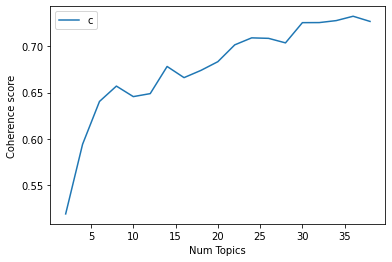

In [169]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [170]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5184
Num Topics = 4  has Coherence Value of 0.5939
Num Topics = 6  has Coherence Value of 0.6404
Num Topics = 8  has Coherence Value of 0.657
Num Topics = 10  has Coherence Value of 0.6456
Num Topics = 12  has Coherence Value of 0.6489
Num Topics = 14  has Coherence Value of 0.6783
Num Topics = 16  has Coherence Value of 0.6662
Num Topics = 18  has Coherence Value of 0.6741
Num Topics = 20  has Coherence Value of 0.6835
Num Topics = 22  has Coherence Value of 0.7018
Num Topics = 24  has Coherence Value of 0.7094
Num Topics = 26  has Coherence Value of 0.7088
Num Topics = 28  has Coherence Value of 0.7039
Num Topics = 30  has Coherence Value of 0.7259
Num Topics = 32  has Coherence Value of 0.7259
Num Topics = 34  has Coherence Value of 0.7281
Num Topics = 36  has Coherence Value of 0.7328
Num Topics = 38  has Coherence Value of 0.7272


The results of the topic modelling are shown in Figure 3, 

The topic model does not automatically assign labels to each topic, each group is assigned a topic number, and contains the keywords and their probability scores. The label assigned is a manual task in which a researcher would assess the group and assign the most likely label, as Blei, et.al.  (2009) writes assigning topic labels from an underlying theme is more of an art than a science. 


In [171]:

optimal_model = model_list[11]

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(2,
  '0.091*"man" + 0.055*"abuse" + 0.042*"join" + 0.036*"tv" + 0.030*"book" + '
  '0.030*"human" + 0.024*"sexually" + 0.024*"make" + 0.024*"production" + '
  '0.024*"issue"'),
 (14,
  '0.095*"late" + 0.071*"group" + 0.047*"sell" + 0.036*"movie" + 0.030*"chief" '
  '+ 0.030*"test" + 0.030*"month" + 0.024*"government" + 0.018*"ash" + '
  '0.018*"drive"'),
 (13,
  '0.078*"covid" + 0.073*"pay" + 0.045*"ahead" + 0.039*"long" + 0.039*"great" '
  '+ 0.028*"day" + 0.028*"nee" + 0.028*"feel" + 0.022*"moment" + 0.022*"rule"'),
 (10,
  '0.055*"ashe" + 0.048*"ashes_t" + 0.041*"save" + 0.034*"stream" + '
  '0.028*"major" + 0.028*"website" + 0.028*"reopen" + 0.021*"robinhood" + '
  '0.021*"line" + 0.021*"condition"'),
 (22,
  '0.067*"year" + 0.042*"plan" + 0.024*"charge" + 0.024*"fast" + 0.024*"user" '
  '+ 0.024*"budget" + 0.024*"asset" + 0.018*"talk" + 0.018*"agree" + '
  '0.018*"demand"'),
 (20,
  '0.125*"people" + 0.034*"give" + 0.034*"back" + 0.028*"accuse" + '
  '0.028*"youth" + 0.028*"debt

Figure 3 shows a sample of the top 10 words in selected topic groups from the optimal number of topics modelled, topics 5, 1 and 14 appear to be related to financial or housing markets with words such as rate, budget, property, buyer, whilst topics 10 appears to align with news articles about covid-19 and vaccinations. Simply assessing the topics in this case does not allow for easy identification of labels.

Implementation of our topic model against the given articles, can assist with labelling of topics, by extracting the Dominant Topic, along with the keywords and text, allows us to get a better understanding of the topic groups, Figure 4 below shows the dominant topic group assigned based on the keywords identified in the text, based on the listed documents, it is difficult to assign Topic Labels, it is clear that in document 4, an article about Pay Cummings who has been appointed Test Captain for the Australian Cricket team has interpreted “Alpha Male” as relating to relationships.

In [175]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1404,"home, family, follow, company, race, variant, ...",scott morrison confirms australia s diplomatic...
1,1,6.0,0.1609,"high, rate, covid, market, share, record, poli...",desperate triple zero calls unanswered as a li...
2,2,2.0,0.1769,"live, pay, woman, change, case, property, run,...",australia news live nsw s omicron covid cluste...
3,3,1.0,0.1480,"late, year, child, school, ash, test, project,...",ashes first test live updates root dismissed f...
4,4,3.0,0.1584,"home, family, follow, company, race, variant, ...",not just another alpha male how pat cummins wi...
5,5,6.0,0.1530,"high, rate, covid, market, share, record, poli...",nathan lyon and subtleties of spin will be cru...
6,6,5.0,0.1623,"time, show, hit, good, price, expect, rise, gr...",i don t want to attend my work christmas party...
7,7,2.0,0.1582,"live, pay, woman, change, case, property, run,...",a hospital drama bursts out of the blocks and ...
8,8,2.0,0.1516,"live, pay, woman, change, case, property, run,...",from susan orlean comes a book about animals e...
9,9,5.0,0.1449,"time, show, hit, good, price, expect, rise, gr...",liberal elder baird encourages berejiklian to ...


In [176]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.0900,"covid, pay, ahead, long, great, day, nee, feel...",scott morrison confirms australia s diplomatic...
1,1,17.0,0.1142,"call, hit, work, economic, night, expert, iron...",desperate triple zero calls unanswered as a li...
2,2,0.0,0.0715,"change, face, run, understand, nation, cricket...",australia news live nsw s omicron covid cluste...
3,3,1.0,0.0589,"high, rate, rise, build, fear, follow, slow, r...",ashes first test live updates root dismissed f...
4,4,3.0,0.0638,"variant, study, executive, stay, investor, fri...",not just another alpha male how pat cummins wi...
5,5,13.0,0.0858,"covid, pay, ahead, long, great, day, nee, feel...",nathan lyon and subtleties of spin will be cru...
6,6,21.0,0.0716,"expect, case, wealth, payment, political, syst...",i don t want to attend my work christmas party...
7,7,16.0,0.0694,"woman, sector, public, strike, shortage, early...",a hospital drama bursts out of the blocks and ...
8,8,2.0,0.0997,"man, abuse, join, tv, book, human, sexually, m...",from susan orlean comes a book about animals e...
9,9,2.0,0.0755,"man, abuse, join, tv, book, human, sexually, m...",liberal elder baird encourages berejiklian to ...


In [173]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1073,"change, face, run, understand, nation, cricket...",grain for hope campaign launched to raise mone...
1,1.0,0.1498,"high, rate, rise, build, fear, follow, slow, r...",why your household budget is shrinkingclimbing...
2,2.0,0.1646,"man, abuse, join, tv, book, human, sexually, m...",former elite swimmers come forward to accuse t...
3,3.0,0.0919,"variant, study, executive, stay, investor, fri...",when she was six hannah suffered a massive str...
4,4.0,0.1171,"market, money, stock, social, housing, full, y...",trump s media deal under scrutiny by market re...


In [177]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"covid, pay, ahead, long, great, day, nee, feel...",18.0,0.0625
1.0,17.0,"call, hit, work, economic, night, expert, iron...",15.0,0.0521
2.0,0.0,"change, face, run, understand, nation, cricket...",17.0,0.0590
3.0,1.0,"high, rate, rise, build, fear, follow, slow, r...",7.0,0.0243
4.0,3.0,"variant, study, executive, stay, investor, fri...",14.0,0.0486
5.0,13.0,"covid, pay, ahead, long, great, day, nee, feel...",12.0,0.0417
6.0,21.0,"expect, case, wealth, payment, political, syst...",17.0,0.0590
7.0,16.0,"woman, sector, public, strike, shortage, early...",16.0,0.0556
8.0,2.0,"man, abuse, join, tv, book, human, sexually, m...",7.0,0.0243
9.0,2.0,"man, abuse, join, tv, book, human, sexually, m...",9.0,0.0312


The chosen implementation of topic modelling for the available corpus was not highly successful, the topic groupings were not specific enough to be able to assess and label the groups by a dominant feature, this limitation may be due to the nature of news headlines, where certain words are selected for their underlying properties, and to appeal to readers. Analysis of the full text of the article may produce better results, as there is not always a clear correlation between the headline and the story beneath. 